## This notebook is to train Catboost model to classify ion images as on-sample provided with a subset of user-labelled images

In [2]:
%matplotlib notebook

from pathlib import Path
from definitions import ROOT_DIR
import numpy as np
import pandas as pd
import os
from datetime import datetime
import tifffile as tif
from scipy.stats import ks_2samp

from catboost import CatBoostClassifier, Pool
from scipy.ndimage import binary_dilation
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from metaspace import SMInstance
sm = SMInstance()

from metaspace.image_processing import clip_hotspots
import getpass

import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize, LogNorm
# from matplotlib import rc
import seaborn as sns

import random

In [3]:
def get_mispredictions(model, X, y):
    """
    Find which values would be mispredicted, returning two lists:
        * indexes of items that would be falsely predicted as positives
        * indexes of items that would be falsely predicted as negatives
        
    cross_val_predict uses a shuffled 5-fold test-train split so that each chunk of 
    20% of the input data gets its own model that was trained on the other 80%, 
    ensuring that the items being predicted aren't included in the training data.
    """
    preds = cross_val_predict(model, X, y)
    mispreds = preds != y
    fpos_idxs = np.flatnonzero(mispreds & ~y)
    fneg_idxs = np.flatnonzero(mispreds & y)
        
    return fpos_idxs, fneg_idxs

In [4]:
def get_images(ds_name, id_map):
    
    ds = sm.dataset(name = ds_name)
    ds_tic_image = ds.tic_image()

    images = []

    for img in ds.all_annotation_images(
        fdr=0.5, 
        database=304, #spotting db
        only_first_isotope=True, 
        scale_intensity=True, 
        hotspot_clipping=False):

        # Exclude annotations with no first-isotopic-image
        if img[0] is not None:

            ion_img = img[0]
            tic_norm_img = np.nan_to_num(ion_img / ds_tic_image)

            images.append({
                'dataset_name': ds_name,
                'formula': img.formula,
                'adduct': img.adduct,
                'neutral_loss': img.neutral_loss or '',
                'image': ion_img,
                'tic_norm_image': tic_norm_img
                })
            
    images_df = pd.DataFrame(images) 
    del(images)

    # add metadata
    results = ds.results(database = 304, include_neutral_losses=True)  
    metadata = results[['ion', 'offSample', 'mz', 'moleculeNames', 'msm']].reset_index()
    metadata.rename(columns={'neutralLoss' : 'neutral_loss'}, inplace=True)
    images_df = images_df.merge(metadata, how='left', on=['formula', 'adduct', 'neutral_loss'])
    images_df = images_df.merge(id_map, on='dataset_name', how='left')
    images_df['filename'] = [f"{x.old_id}_{x.formula}_{x.adduct}{x.neutral_loss}.png" for x in images_df.itertuples()]
    images_df['row_id'] = [f"{x.old_id}_{x.formula}_{x.adduct}{x.neutral_loss}" for x in images_df.itertuples()]

    return images_df

def prepare_tissue_mask(p_mask):
    mask = tif.imread(p_mask)
    mask = mask / 255 # scale to only 0 and 1 
    mask = binary_dilation(mask, iterations=3)
    return mask

def calc_far_bg(mask):
    """Gets mask for background pixels that are away from the tissue by n=7 dilation cycles"""
    far_bg = ~binary_dilation(mask, iterations=7)
    return far_bg

def occ(px):
    """Calculates non-zero % of the given array"""
    return np.count_nonzero(px) / px.size

def calculate_metrics(images_df, binary):

    metrics = []
    for row in images_df.itertuples():

        mask = binary == 1
        bg = binary == 0
        far_bg = calc_far_bg(mask)

        in_mask = row.image[mask]        
        in_bg = row.image[bg]
        in_far_bg = row.image[far_bg]
        
        in_mask_tic = row.tic_norm_image[mask]
        in_bg_tic = row.tic_norm_image[bg]
        in_far_bg_tic = row.tic_norm_image[far_bg]
        
        # Calculate KS statistic 
        d_stat, p_val = ks_2samp(in_mask, in_bg)
        d_stat_tic, p_val_tic = ks_2samp(in_mask_tic, in_bg_tic)

#       If there is more signal in off-sample area compared to the well area, make statistic negative
        if np.mean(in_bg) > np.mean(in_mask):
            d_stat = d_stat*-1
        if np.mean(in_bg_tic) > np.mean(in_mask_tic):
            d_stat_tic = d_stat_tic*-1

        metrics.append({
            'dataset_name' : row.dataset_name,
            'formula' : row.formula,
            'adduct' : row.adduct,
            'neutral_loss' : row.neutral_loss,
            'ion' : row.ion,
            
            'sample_intensity' : np.mean(in_mask),
            'tic_sample_intensity' : np.mean(in_mask_tic),
            'far_bgr_corrected_intensity' : np.mean(in_mask) - np.mean(in_far_bg),
            
            'intensity_ratio': np.mean(in_mask) / (np.mean(in_bg)+0.001),
            'intensity_vs_far_bg_ratio': np.mean(in_mask) / (np.mean(in_far_bg) + 0.001),
            'tic_intensity_ratio': np.mean(in_mask_tic) / (np.mean(in_bg_tic)+0.001),
            'tic_intensity_vs_far_bg_ratio': np.mean(in_mask_tic) / (np.mean(in_far_bg) + 0.001),
            
            'image_occupancy' : occ(row.image),
            'sample_occupancy' : occ(in_mask),
            'bg_occupancy': occ(in_bg),
            'far_bgr_occupancy':occ(in_far_bg),
            'occupancy_ratio': occ(in_mask) / (occ(in_bg)+0.001),
            'occupancy_vs_far_bg_ratio' : occ(in_mask) / (occ(in_far_bg) + 0.001),
    
            'ks_score' : d_stat, 
            'ks_score_tic' : p_val, # note that there was a typo in this block
            'ks_pval' : p_val_tic, # also here
            'ks_pval_tic' : p_val_tic, # also here
        })

    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [5]:
p_home = Path(ROOT_DIR) / "spotting_vs_metaspace"
p_analysis = p_home / "catboost"
p_masks = p_analysis / 'tissue_masks'
p_labels = p_analysis / r"labels_for_model_training"
p_id_map = p_analysis / "id_map.csv"

timestamp = datetime.now().strftime("%d-%b-%Y") 

# Paths for evaluation
p_eval = p_analysis/ "model_results"
p_metrics = p_eval / "metrics.csv"
p_eval_preds = p_eval / 'predictions.csv'
p_predictions = p_eval / f"tissue_predictions_{timestamp}.csv"
p_predictions_curated = p_eval / f"all_predictions_curated_{timestamp}.csv"
p_model = p_eval / "model.json"
# False positives/negatives - preview output from model prediction for molecules with known labels
# Note that all files in these directories are cleared before a prediction run
p_eval_fpos = p_eval / 'false_positives'
p_eval_fneg = p_eval / 'false_negatives'
p_eval_tpos = p_eval / 'true_positives'
p_eval_tneg = p_eval / 'true_negatives'
# Unknown positives/negatives - preview output from model prediction for molecules with no label
# Note that all files in these directories are cleared before a prediction run
p_eval_upos = p_eval / 'unknown_positives'
p_eval_uneg = p_eval / 'unknown_negatives'
# Manually labeled positives/negatives - Move preview files from any of the above directories into 
# these directories to add to the labelled data. Make sure to re-run the appropriate steps 
# in "Input data" to detect the changes
p_eval_lpos = p_eval / 'manual_label_positives'
p_eval_lneg = p_eval / 'manual_label_negatives'

# Directories for three-state positive/unsure/negative classification
p_tri_pos = p_eval / 'three-state' / 'positive'
p_tri_unk = p_eval / 'three-state' / 'unsure'
p_tri_neg = p_eval / 'three-state' / 'negative'

- Get dataset names (from tissue mask folder)

In [6]:
mask_names = list(p_masks.rglob("*.tif"))
dataset_names = [x.stem + " - extended" for x in mask_names]

- Get images for each dataset
- Download images from metaspace or load them in if they were pre-saved

In [ ]:
# Log into metaspace
sm = SMInstance(host='https://metaspace2020.eu')

if not sm.logged_in():
    # Using getpass here prevents the API key from being accidentally saved with this notebook.
    api_key = getpass.getpass(prompt='API key: ', stream=None)
    sm.login(api_key=api_key)

- Calculate metrics for individual datasets

In [88]:
metric_list = []
k=0
for ds_name, p_mask in list(zip(dataset_names, mask_names)):
    print(ds_name, k)
    k+=1    
    
#     images_df = get_images(ds_name, id_map)
#     images_df.to_pickle(p_eval / f"{ds_name}_images.pickle")
    images_df = pd.read_pickle(p_eval / f"{ds_name}_images.pickle")
    mask = prepare_tissue_mask(p_mask)
    if images_df.image[0].shape != mask.shape:
        print(ds_name, p_mask, "problem\n")
        break
    metrics = calculate_metrics(images_df, mask)
    metric_list.append(metrics)
    del(images_df)

metrics_df = pd.concat(metric_list)
metrics_df.to_csv(p_metrics)

02112020_VS_NH1_11-2A_treatment_att29_px45_109x168_DAN_neg Cloned - extended 0
02112020_VS_NH1_18-1_control_att29_px45_96x91_DAN_neg Cloned - extended 1
071119_Opt_CBO_Brain_maldi5_168x164p50_DAN_neg Cloned - extended 2
20191021_Opt_Sanger_Brain_150sx75p_DANx_neg Cloned - extended 3
20191022_Opt_Sanger_Brain_150sx75p_DHB_pos Cloned - extended 4
2020-07-18_ME_Liver_Naive_DHB_Pos_120-1200_300x300_25umss Cloned - extended 5
2020-07-19_ME_Liver_UV_DHB_Pos_120-1200_300x275_25umss_32at Cloned - extended 6
2020-08-27_ME_X130L2_29at_25umss_420x240 Cloned - extended 7
2020-08-28_ME_X190L4_29at_25umss_240x200 Cloned - extended 8
2020-08-28_ME_X190L6_10um_29at_25umss_350x300 Cloned - extended 9


100%|████████████████████████████████████████| 5319/5319 [00:41<00:00, 129.34it/s]                                     


2020-09-06_ME_X190_L6_5um_25umss_CHCA_Pos_340x320_31at Cloned - extended 10
2020-09-17_ME_X190_L1_15um_20umss_DHB_Pos_475x220_31at Cloned - extended 11
2020-10-26_ME_L11_Slide9_210x360_20um_ss_31at Cloned - extended 12
2020-10-26_ME_L5_Slide9_330x170_20um_ss_31at Cloned - extended 13
2020-10-28_ME_L2_Slide9_230x300_20um_ss_31at Cloned - extended 14
2020-10-28_ME_VS_NHI-11-2B_DHB_Pos_40um_ss_116x182_31AT_pos Cloned - extended 15
2020-10-28_ME_VS_NHI-18-2_DHB_Pos_40um_ss_87x107_pos Cloned - extended 16
2021-04-26_ME_X190L1-9_29at_25umss_310x190 Cloned - extended 17
2021-04-27_ME_X190L3-9_29at_25umss_152x142 Cloned - extended 18
2021-04-28_ME_X190L6-9_29at_25umss_240x217 Cloned - extended 19
2021-04-29_ME_X190L8-8_29at_25umss_134x320_concat Cloned - extended 20
2021-06-30_ME_X190L5-7_29at_20umss_250x200 Cloned - extended 21
2021-07-03_ME_X190L6-8_29at_20umss_280x230 Cloned - extended 22
26102018_CBO_SHA_brainDAN_p100_s80 Cloned - extended 23
ZM6_long_B6female_epsilon_LI_DAN27repeat_s150 C

In [16]:
# or load pre-saved
metrics_df = pd.read_csv(p_metrics, index_col=0)
metrics_df.neutral_loss = metrics_df.neutral_loss.fillna("")

- Import manual labels

In [20]:
labelled_set = []

for label in ['pass', 'fail']:
    if label == 'pass':
        score = 1
    else: score = 0
    
    for img in (p_labels / label).rglob("*.png"):
        filename = img.name
    
        labelled_set.append({
            'filename':filename,
            'score':score
        })
        
labelled_anns_df = pd.DataFrame(labelled_set)
labelled_anns_df

,filename,score
0,2022-01-03_12h04m13s_C10H12N2O_+Na.png,1
1,2022-01-03_12h04m13s_C10H14N5O7P_+H.png,1
2,2022-01-03_12h04m13s_C10H14N5O7P_+K.png,1
3,2022-01-03_12h04m13s_C10H14N5O7P_+Na.png,1
4,2022-01-03_12h04m13s_C10H17N3O6S_+H.png,1
...,...,...
4910,2022-01-21_11h29m55s_C16H32O2_-H.png,0
4911,2022-01-21_11h29m55s_C19H19N7O6_-H.png,0
4912,2022-01-21_11h29m55s_C21H41O7P_+Cl.png,0
4913,2022-01-21_11h29m55s_C29H50O2_+Cl.png,0


- Combine metrics and manual labels

In [107]:
# Add in dataset ids and expected filenames of labelled images
id_map = pd.read_csv(p_id_map)
metrics_df = metrics_df.merge(id_map, on='dataset_name', how='left')
metrics_df['filename'] = [f"{x.old_id}_{x.formula}_{x.adduct}{x.neutral_loss}.png" for x in metrics_df.itertuples()]
metrics_df['row_id'] = [f"{x.old_id}_{x.formula}_{x.adduct}{x.neutral_loss}" for x in metrics_df.itertuples()]

# Combine metrics and manual labels
merged_df = metrics_df.merge(labelled_anns_df, on=['filename'], how='left')
merged_df.set_index('row_id', inplace=True)

In [112]:
# Prepare input data
input_df = merged_df[~merged_df.score.isna()]  # Exclude unlabeled rows
input_df = input_df.sample(frac=1.0)  # Shuffle rows
X = input_df.drop(columns=['dataset_name', 'formula', 'adduct', 'neutral_loss', 'ion', 'new_id', 'old_id',
       'filename', 'score']) # Exclude columns that are not features
y = input_df.score.astype('i').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Evaluate models

In [ ]:
models_to_eval = [
    CatBoostClassifier(verbose=False),
#     LinearSVC(class_weight='balanced'),
#     DecisionTreeClassifier(max_depth=3),
#     BaggingClassifier(LinearSVC(), n_estimators=3, bootstrap_features=True),
]
max_features_to_consider = 4

eval_results = []

for model in models_to_eval:
    model_name = str(model)
    for n_features in range(1, max_features_to_consider + 1):
        print(model_name, n_features)
        # SequentialFeatureSelector finds the set of N features that give the best scores
        sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, n_jobs=-1, cv=RepeatedStratifiedKFold())
        sfs.fit(X_train, y_train)
        best_features = X.columns[sfs.support_]
        
        # Evaluate using cross-validation
        X_subset = X[best_features].values
        fpos_idxs, fneg_idxs = get_mispredictions(model, X_subset, y)
        # Use a repeating cross-validator so that results are averaged over ~50 runs
        cv = RepeatedStratifiedKFold()
        cv_scores = cross_validate(model, X_subset, y, cv=cv, scoring=['accuracy','f1'])
        cv_accuracy = np.mean(cv_scores['test_accuracy'])
        cv_f1 = np.mean(cv_scores['test_f1'])
        
        # Evaluate using hold-out validation
        trained_subset_model = clone(model).fit(X_train[best_features].values, y_train)
        holdout_accuracy = trained_subset_model.score(X_test[best_features].values, y_test)
        holdout_f1 = f1_score(y_test, trained_subset_model.predict(X_test[best_features].values))
        
        eval_results.append({
            'model': model_name,
            'n_features': n_features,
            'features': ', '.join(best_features),
            'cv_accuracy': cv_accuracy,
            'cv_f1': cv_f1,
            'holdout_accuracy': holdout_accuracy,
            'holdout_f1': holdout_f1,
            'n_fpos': len(fpos_idxs),
            'n_fneg': len(fneg_idxs),
            # Uncomment to include the idxs of false positives/negatives to see which
            # inputs are repeatedly mispredicted regardless of the model
            # 'fpos_idxs': fpos_idxs,
            # 'fneg_idxs': fneg_idxs,
        })
        
eval_results_df = pd.DataFrame(eval_results)

eval_results_df

In [ ]:
print(eval_results_df.features.iloc[0])
print(eval_results_df.features.iloc[1])
print(eval_results_df.features.iloc[2])
print(eval_results_df.features.iloc[3])


# Show behavior of accuracy as number of features increases
# plt.figure()
sns.lineplot(data=eval_results_df, x='n_features', y='cv_accuracy', hue='model')

In [ ]:
# get eval just for a particular set of features

# Models to try
models_to_eval = [
    CatBoostClassifier(verbose=False)
]

features = [
            'intensity_vs_far_bg_ratio', 
            'occupancy_ratio', 
            'ks_score', 
            'ks_pval',
            'image_occupancy',
            'tic_intensity_vs_far_bg_ratio']

eval_results = []

for model in models_to_eval:
    model_name = str(model)
    print(model_name, features)
    # Evaluate using cross-validation
    X_subset = X[features].values
    fpos_idxs, fneg_idxs = get_mispredictions(model, X_subset, y)
    # Use a repeating cross-validator so that results are averaged over ~50 runs
    cv = RepeatedStratifiedKFold()
    cv_scores = cross_validate(model, X_subset, y, cv=cv, scoring=['accuracy','f1'])
    cv_accuracy = np.mean(cv_scores['test_accuracy'])
    cv_f1 = np.mean(cv_scores['test_f1'])
    
    # Evaluate using hold-out validation
    trained_subset_model = clone(model).fit(X_train[features].values, y_train)
    holdout_accuracy = trained_subset_model.score(X_test[features].values, y_test)
    holdout_f1 = f1_score(y_test, trained_subset_model.predict(X_test[features].values))
    
    eval_results.append({
        'model': model_name,
#         'n_features': n_features,
        'features': ', '.join(features),
        'cv_accuracy': cv_accuracy,
        'cv_f1': cv_f1,
        'holdout_accuracy': holdout_accuracy,
        'holdout_f1': holdout_f1,
        'n_fpos': len(fpos_idxs),
        'n_fneg': len(fneg_idxs),
        # Uncomment to include the idxs of false positives/negatives to see which
        # inputs are repeatedly mispredicted regardless of the model
        # 'fpos_idxs': fpos_idxs,
        # 'fneg_idxs': fneg_idxs,
    })
        
eval_results_df = pd.DataFrame(eval_results)
eval_results_df

## Train a new model

In [113]:
model = CatBoostClassifier(verbose=False)
features = [
            'intensity_vs_far_bg_ratio', 
            'occupancy_ratio', 
            'ks_score', 
            'ks_pval',
            'image_occupancy',
            'tic_intensity_vs_far_bg_ratio']

In [114]:
# Train the model on labeled data
train_df = merged_df[~merged_df.score.isna()]  # Exclude unlabeled rows
train_df = train_df.sample(frac=1.0)  # Shuffle rows
X_df = train_df.drop(columns=['score'])[features]
y = train_df.score.astype('i').values
trained_model = clone(model).fit(X_df.values, y)

# Make predictions for unlabeled data
unlabeled_df = merged_df[merged_df.score.isna()][features]
unlabeled_predictions_df = pd.DataFrame({
    'pred_val': trained_model.predict_proba(unlabeled_df.values)[:, 1]
}, index=unlabeled_df.index)

# Make cross-validated predictions for labeled data
labeled_predictions_df = pd.DataFrame({
    'pred_val': cross_val_predict(model, X_df.values, y, method='predict_proba')[:, 1]
}, index=X_df.index)

# Combine predictions
predictions_df = pd.concat([unlabeled_predictions_df, labeled_predictions_df])

## Both options: Assign labels to predictions

In [115]:
output_df = merged_df.join(predictions_df)

# Add two-state and three-state classes
output_df['prediction'] = np.where(output_df.pred_val < 0.75, 0, 1)
# unsure_range = [0.2, 0.75] # Lowest & highest values to include in the "unsure" class
# This assigns 0 = negative, 1 = unsure, 2 = positive
# output_df['pred_threestate'] = np.digitize(output_df.pred_val, unsure_range)

# write predicitons csv file
output_df.to_csv(p_predictions)

<IPython.core.display.Javascript object>


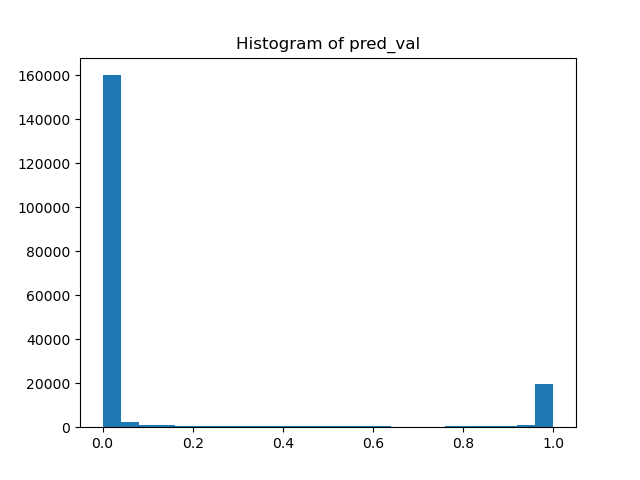

In [121]:
plt.figure()
plt.title("Histogram of pred_val")
plt.hist(output_df.pred_val.ravel(), 25)
plt.show()

### Write image files into false positives, false negatives, etc.

In [117]:
def colorize_image_with_mask(image, mask):
    """Plotting function for combining a colorized ion image with a spot mask"""
    image = clip_hotspots(image)
    on_spot_colorized = plt.cm.cividis(image)
    off_spot_colorized = plt.cm.magma(image)
    return np.where(mask[:,:,np.newaxis], on_spot_colorized, off_spot_colorized)
    
def save_image_with_mask(image, mask, fname):
    plt.imsave(fname, colorize_image_with_mask(image, mask))
    
    
def save_image(image, fname):
    plt.imsave(fname, clip_hotspots(image))

In [118]:
# Clean output directories
for output_path in [
    p_eval_fpos, p_eval_fneg, p_eval_tpos, p_eval_tneg, p_eval_upos, p_eval_uneg, 
]:
    output_path.mkdir(parents=True, exist_ok=True)
    for f in output_path.glob('*.png'):
        f.unlink()  # Delete existing files

for dataset_name in output_df.dataset_name.unique():
    
    #load inages
    images_df = pd.read_pickle(p_eval / f"{dataset_name}_images.pickle")
    images_df.set_index('row_id', inplace=True)
    
    subset = output_df[output_df.dataset_name == dataset_name]
    
    # Write images with two-state classification
    for row in subset.itertuples():
        
        image_to_write = images_df.loc[row[0], 'image']

        # Figure out which directory to use
        if row.score == 0:
            twostate_path = [p_eval_tneg, p_eval_fpos][row.prediction]
        elif row.score == 1:
            twostate_path = [p_eval_fneg, p_eval_tpos][row.prediction]
        else:
            twostate_path = [p_eval_uneg, p_eval_upos][row.prediction]

        save_image(image_to_write, twostate_path / row.filename)

# Save trained model

Note: This JSON export only works for CatBoost. 
scikit-learn models don't have a standardized export format.

In [119]:
trained_model.save_model(p_model, format='json', pool=Pool(X_df.values, y))